# Simulador de colisão de partículas

## Instalando dependências

In [ ]:
# ! pip install scienceplots

In [1]:
# References: 
#   Code:
#       https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid28.ipynb
#   Youtube:
#       Boltzmann       -   https://www.youtube.com/watch?v=65kl4eE9ovI
#       Boost with gpu  -   https://www.youtube.com/watch?v=iSEAidM-DDI

import numpy as np
import matplotlib # matplotlib
import scienceplots # pip install scienceplots
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from itertools import combinations
from datetime import datetime
import time

plt.style.use(['science', 'notebook'])

## Codificando Classe

In [67]:
class ColisionArena:
    def __init__(self, n_particles, raio: int = 0.03, speed: int = 500, ciclos: int = 1000):
        self.reset_variables()
        self.n_particles = abs(int(n_particles))
        self.speed = speed
        self.ciclos = abs(ciclos)
        self.raio = abs(raio)

    def reset_variables(self):
        self.radius = 0
        self.r = []
        self.ixr = []
        self.ixl = []
        self.v = []
        self.ids_pairs = []
        self.x_pairs = []
        self.dx_pairs = []
        self.y_pairs = []
        self.dy_pairs = []
        self.d_pairs = []
        self.rs = []
        self.vs = []

    def reset(self):
        self.reset_variables() # clean variables

        # randomize the particles
        self.r = np.random.random((2, self.n_particles))
        
        # Color particles the start on either side
        self.ixr = self.r[0] > 0.5  #right
        self.ixl = self.r[0] <= 0.5 #left

        # define velocity 500m/s
        self.v = np.zeros((2, self.n_particles))
        # self.v[0][self.ixr] = abs(np.random.random((1,10)).round(2)*1000) * -1
        # self.v[0][self.ixl] = abs(np.random.random((1,10)).round(2)*1000)
        self.v[0][self.ixr] = np.random.randint(self.speed, self.speed*3, size=self.v[0][self.ixr].shape) * -1
        self.v[0][self.ixl] = np.random.randint(self.speed, self.speed*3, size=self.v[0][self.ixl].shape)
        # print('self.v[0][self.ixr]', self.v[0][self.ixr])
        # self.v[0][self.ixr] = abs(self.speed) * -1
        # self.v[0][self.ixl] = abs(self.speed)

        self.ids = np.arange(self.n_particles)

        # calculating distance between all pairs
        self.ids_pairs = np.asarray(list(combinations(self.ids, 2)))

        self.x_pairs = np.array([self.r[0][self.ids_pairs[:,0]], 
                                 self.r[0][self.ids_pairs[:,1]]]).T

        # calculating diference between all pairs
        self.dx_pairs = np.diff(self.x_pairs, axis=1).ravel()
    
        # doing the math
        self.x_pairs = np.array([self.r[0][self.ids_pairs[:,0]], 
                                 self.r[0][self.ids_pairs[:,1]]]).T
        self.y_pairs = np.array([self.r[1][self.ids_pairs[:,0]], 
                                 self.r[1][self.ids_pairs[:,1]]]).T
        self.dx_pairs = np.diff(self.x_pairs, axis=1).ravel()
        self.dy_pairs = np.diff(self.y_pairs, axis=1).ravel()
        self.d_pairs = np.sqrt(self.dx_pairs**2 + self.dy_pairs**2)

    def show_plot(self):
        plt.figure(figsize=(5,5))
        plt.scatter(self.r[0][self.ixr], self.r[1][self.ixr], color='r', s=6)
        plt.scatter(self.r[0][self.ixl], self.r[1][self.ixl], color='b', s=6)
        plt.show()

    def get_delta_pairs(self, x, ids_pairs):
        return np.diff(np.array([x[ids_pairs[:,0]], 
                                 x[ids_pairs[:,1]]]).T, axis=1).ravel()

    def get_deltad_pairs(self, r, ids_pairs):
        return np.sqrt(self.get_delta_pairs(r[0], ids_pairs)**2 + \
                       self.get_delta_pairs(r[1], ids_pairs)**2)

    def compute_new_v(self, v1, v2, r1, r2):
        v1new = v1 - ((v1-v2)*(r1-r2)).sum(axis=0)/np.sum((r1-r2)**2, axis=0) * (r1-r2)
        v2new = v2 - ((v1-v2)*(r1-r2)).sum(axis=0)/np.sum((r2-r1)**2, axis=0) * (r2-r1)
        return v1new, v2new

    def motion(self, r, v, id_pairs, ts, dt, d_cutoff):
        rs = np.zeros((ts, r.shape[0], r.shape[1]))
        vs = np.zeros((ts, v.shape[0], v.shape[1]))
        # Initial State
        rs[0] = r.copy()
        vs[0] = v.copy()
        for i in range(1, ts):
            ic = id_pairs[self.get_deltad_pairs(r, self.ids_pairs) < d_cutoff]
            v[:,ic[:,0]], v[:,ic[:,1]] = self.compute_new_v(v[:,ic[:,0]], 
                                                            v[:,ic[:,1]], 
                                                            r[:,ic[:,0]], 
                                                            r[:,ic[:,1]])
            
            v[0,r[0]>1] = -np.abs(v[0,r[0]>1])
            v[0,r[0]<0] = np.abs(v[0,r[0]<0])
            v[1,r[1]>1] = -np.abs(v[1,r[1]>1])
            v[1,r[1]<0] = np.abs(v[1,r[1]<0])
            
            r = r + v*dt
            rs[i] = r.copy()
            vs[i] = v.copy()

        return rs, vs
    
    def create_simulation(self):
        # Crafting the simulation
        try:
            print(f'Crafting the simulation at {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
            start_time = time.perf_counter()

            # preparing enviroment
            self.reset()
            self.radius = self.raio

            # running simulation
            self.rs, self.vs = self.motion(
                self.r, 
                self.v, 
                self.ids_pairs,
                ts=self.ciclos,
                dt=0.000008,
                d_cutoff=2*self.radius
            )
        finally:
            print(f'- Elapsed time for simulation {time.perf_counter() - start_time} secs')
        
        # Crafting the animation
        try:
            print(f'Crafting the animation at {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
            start_time = time.perf_counter()
            self.filename = f'collision_simulation_{datetime.now().strftime("%Y%m%dT%H%M%S")}.mp4'
            # self.filename = f'collision_simulation_{datetime.now().strftime("%Y%m%dT%H%M%S")}.gif'
            print(f'- Animation: {self.filename}')
            self.make_animation()
        finally:
            print(f'- Elapsed time for create animation {time.perf_counter() - start_time} secs')
            print(f'Simulation done at {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

    def make_animation(self):
        fig, ax = plt.subplots(1, 1, figsize=(5,5))
        
        # def animate(i):
        #     ax.clear()
        #     xred, yred = self.rs[i][0][self.ixr], self.rs[i][1][self.ixr]
        #     xblue, yblue = self.rs[i][0][self.ixl], self.rs[i][1][self.ixl]
        #     circles_red = [plt.Circle((xi, yi), radius=self.radius, linewidth=0) for xi,yi in zip(xred,yred)]
        #     circles_blue = [plt.Circle((xi, yi), radius=self.radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
        #     cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
        #     cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
        #     ax.add_collection(cred)
        #     ax.add_collection(cblue)
        #     ax.set_xlim(0,1)
        #     ax.set_ylim(0,1)

        # # ax.set_title('Animação')
        # ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50) #, blit=True)
        # ani.save(self.filename,
        #             writer='pillow',
        #             fps=30,
        #             dpi=100)

        ax.clear()
        vmin = 0
        vmax = 1
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_title(f'Particle Collision Simulation')
        ax.set_xlabel(f'{self.n_particles} Particles, {self.raio} Ratio, {self.ciclos} Cycles, {self.speed}~{self.speed*3} m/s Initial speed',
                        loc='right',
                        fontsize=8)
        ax.set_ylabel(f'Author: Herson Melo <hersonpc@gmail.com> (C) 2023-05-03',
                        loc='center',
                        fontweight='bold',
                        fontsize=7,
                        family='monospace')
        
        markersize = 2 * self.radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
        red, = ax.plot([], [], 'o', color='red', markersize=markersize)
        blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

        def animate(i):
            xred, yred = self.rs[i][0][self.ixr], self.rs[i][1][self.ixr]
            xblue, yblue = self.rs[i][0][self.ixl], self.rs[i][1][self.ixl]
            red.set_data(xred, yred)
            blue.set_data(xblue, yblue)
            return red, blue

        writer = animation.FFMpegWriter(fps=30)
        ani = animation.FuncAnimation(fig, animate, 
                                        frames=self.ciclos,
                                        interval=50,
                                        blit=True)
        ani.save(self.filename, writer=writer, dpi=200)

    def show_animation_gif(self, filename: str = None):
        from IPython.display import Image

        if filename:
            return Image(open(filename,'rb').read())

        print(f'- Gif: {self.filename}')
        return Image(open(self.filename,'rb').read())

    def show_animation_video(self, filename: str = None):
        from IPython.display import HTML
        from base64 import b64encode
        if filename:
            mp4 = open(filename,'rb').read()
        else:    
            mp4 = open(self.filename,'rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        output = HTML("""
                <video width=400 controls>
                    <source src="%s" type="video/mp4">
                </video>
            """ % data_url)
        return output


Crafting the simulation at 2023-05-03 18:45:48
- Elapsed time for simulation 9.020165874993836 secs
Crafting the animation at 2023-05-03 18:45:57
- Animation: collision_simulation_20230503T184557.mp4
- Elapsed time for create animation 201.6491437079967 secs
Simulation done at 2023-05-03 18:49:18


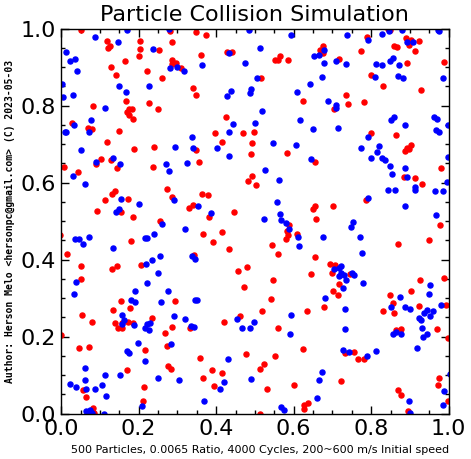

In [68]:
arena = ColisionArena(n_particles=500, raio=0.0065, speed=200, ciclos=4000)
arena.create_simulation()

Crafting the simulation at 2023-05-03 18:54:21
- Elapsed time for simulation 0.31430912500218255 secs
Crafting the animation at 2023-05-03 18:54:22
- Animation: collision_simulation_20230503T185422.mp4
- Elapsed time for create animation 161.3522627909988 secs
Simulation done at 2023-05-03 18:57:03


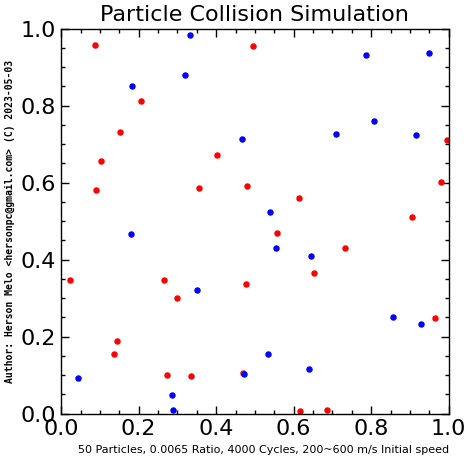

In [70]:
arena = ColisionArena(n_particles=50, raio=0.0065, speed=200, ciclos=4000)
arena.create_simulation()

In [33]:
# arena.show_animation_video()

## Resultados da simulação de colisão das partículas

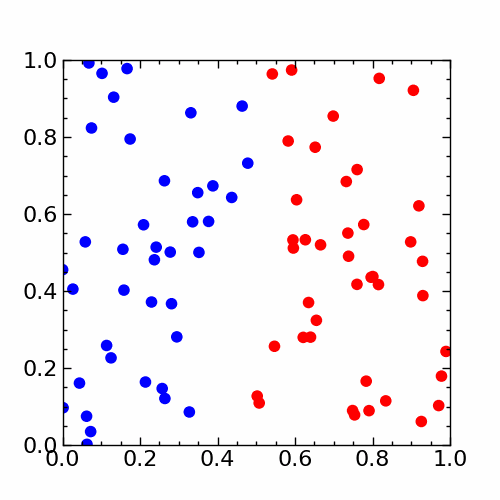

In [69]:
arena.show_animation_gif("collision_simulation_20230503T061547.gif")